In [1]:
from google.colab import drive
drive.mount("/content/test")

Drive already mounted at /content/test; to attempt to forcibly remount, call drive.mount("/content/test", force_remount=True).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

data1 = pd.read_csv("/content/test1.csv", index_col = 0).T
data2 = pd.read_csv("/content/test2.csv", index_col = 0).T
cell_types1 = pd.read_csv("/content/celltypes1.csv", index_col = 0)
cell_types2 = pd.read_csv("/content/celltypes2.csv", index_col = 0)
cell_types1.columns = ["cell_type"]
cell_types2.columns = ["cell_type"]
data = pd.concat([data1, data2])
data.index = data.index.str.replace(r"\.", "-", regex=True)
cell_types = pd.concat([cell_types1, cell_types2])
cell_types.index = data.index

In [2]:
data_merged = pd.merge(data, cell_types, left_index=True, right_index=True)
count_occur = data_merged.sum()
# drop probes with no values
data_merged = data_merged.drop(count_occur.keys()[count_occur == 0], axis=1)
X, y = data_merged.iloc[:, :-1].values, data_merged["cell_type"]
y = np.unique(y, return_inverse=True)[1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

In [3]:
import tensorflow as tf
from tensorflow import keras
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [5]:
n_components = 15
net = tf.keras.models.Sequential([
    tf.keras.layers.Dense(15, input_dim=n_components, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(15, activation="relu"),
    tf.keras.layers.Dense(9, activation="softmax"),
])
net.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
pca = PCA(n_components=n_components)
net.fit(pca.fit_transform(X_train), y_train, epochs=50, batch_size=10, 
        validation_data=(pca.transform(X_test), y_test))

Epoch 1/50
588/588 [==============================] - 2s 3ms/step - loss: 1.9471 - accuracy: 0.6024 - val_loss: 0.7290 - val_accuracy: 0.7584
Epoch 2/50
588/588 [==============================] - 1s 2ms/step - loss: 0.5948 - accuracy: 0.7908 - val_loss: 0.6112 - val_accuracy: 0.8012
Epoch 3/50
588/588 [==============================] - 1s 2ms/step - loss: 0.4852 - accuracy: 0.8259 - val_loss: 0.5664 - val_accuracy: 0.8165
Epoch 4/50
588/588 [==============================] - 2s 3ms/step - loss: 0.4359 - accuracy: 0.8440 - val_loss: 0.5509 - val_accuracy: 0.8364
Epoch 5/50
588/588 [==============================] - 2s 3ms/step - loss: 0.4108 - accuracy: 0.8512 - val_loss: 0.5168 - val_accuracy: 0.8532
Epoch 6/50
588/588 [==============================] - 2s 4ms/step - loss: 0.3875 - accuracy: 0.8605 - val_loss: 0.4989 - val_accuracy: 0.8486
Epoch 7/50
588/588 [==============================] - 2s 3ms/step - loss: 0.3732 - accuracy: 0.8646 - val_loss: 0.5918 - val_accuracy: 0.8211
Epoch 

In [6]:
net.evaluate(pca.transform(X_test), y_test)


21/21 [==============================] - 0s 2ms/step - loss: 0.6316 - accuracy: 0.8731


[0.6316456198692322, 0.8730886578559875]

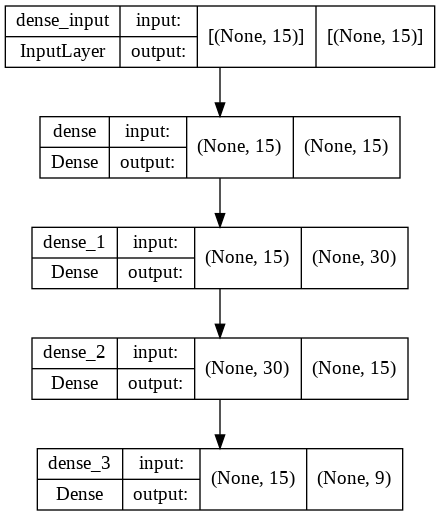

In [10]:
from keras.utils.vis_utils import plot_model
plot_model(net, show_shapes=True, show_layer_names=True)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(knn, pca.transform(X_test), y_test, labels = np.unique(y_test), ax=ax)
ax.set_title("Figure 5: kNN Classifier Confusion Matrix")

#### MoE

In [4]:
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=1)

In [8]:
# Naive, SVC
def moe_score(X_train, X_test, y_train, y_test):
  n_components = 15
  pca = PCA(n_components=n_components)
  X_tra_train = pca.fit_transform(X_train)
  X_tra_test = pca.transform(X_test)

  C = 2
  kmeans = KMeans(n_clusters=C, random_state=0).fit(X_tra_train)
  idx = kmeans.labels_
  gNet = GaussianNB().fit(X_tra_train, idx)

  Exp = []
  for k in range(C):
    Exp.append(SVC(kernel="linear").fit(X_tra_train[idx==k], y_train[idx==k]))

  idx_pred = gNet.predict(X_tra_test)
  results = np.empty((X_tra_test.shape[0], 1), dtype=int)
  for k in range(C):
      results[idx_pred==k] = np.reshape(Exp[k].predict(X_tra_test[idx_pred==k]), (-1, 1))
  print("accuracy: ", accuracy_score(y_test, results.flatten()))
  for k in range(C):
    print(f'Expert #{k}\n',accuracy_score(y_test[idx_pred==k],results[idx_pred==k]))
  return accuracy_score(y_test, results.flatten())

skf = StratifiedKFold(n_splits=10)
scores = [moe_score(X[a, :], X[b, :], y[a], y[b]) for a, b in skf.split(X, y)]

accuracy:  0.8715596330275229
Expert #0
 0.8663967611336032
Expert #1
 0.8875
accuracy:  0.8807339449541285
Expert #0
 0.8823529411764706
Expert #1
 0.8757763975155279
accuracy:  0.8944954128440367
Expert #0
 0.884393063583815
Expert #1
 0.8981288981288982
accuracy:  0.8776758409785933
Expert #0
 0.8940936863543788
Expert #1
 0.8282208588957055
accuracy:  0.886676875957121
Expert #0
 0.8543046357615894
Expert #1
 0.896414342629482
accuracy:  0.877488514548239
Expert #0
 0.9019607843137255
Expert #1
 0.87
accuracy:  0.8805513016845329
Expert #0
 0.892
Expert #1
 0.8431372549019608
accuracy:  0.8805513016845329
Expert #0
 0.8533333333333334
Expert #1
 0.8886679920477137
accuracy:  0.885145482388974
Expert #0
 0.8903225806451613
Expert #1
 0.8835341365461847
accuracy:  0.885145482388974
Expert #0
 0.8857142857142857
Expert #1
 0.8834355828220859


In [12]:
np.mean(scores)

0.8820023790456656

In [13]:
# Naive, Naive
def moe_score(X_train, X_test, y_train, y_test):
  n_components = 15
  pca = PCA(n_components=n_components)
  X_tra_train = pca.fit_transform(X_train)
  X_tra_test = pca.transform(X_test)

  C = 2
  kmeans = KMeans(n_clusters=C, random_state=0).fit(X_tra_train)
  idx = kmeans.labels_
  gNet = GaussianNB().fit(X_tra_train, idx)

  Exp = []
  for k in range(C):
    Exp.append(GaussianNB().fit(X_tra_train[idx==k], y_train[idx==k]))

  idx_pred = gNet.predict(X_tra_test)
  results = np.empty((X_tra_test.shape[0], 1), dtype=int)
  for k in range(C):
      results[idx_pred==k] = np.reshape(Exp[k].predict(X_tra_test[idx_pred==k]), (-1, 1))
  print("accuracy: ", accuracy_score(y_test, results.flatten()))
  for k in range(C):
    print(f'Expert #{k}\n',accuracy_score(y_test[idx_pred==k],results[idx_pred==k]))
  return accuracy_score(y_test, results.flatten())

skf = StratifiedKFold(n_splits=10)
np.mean([moe_score(X[a, :], X[b, :], y[a], y[b]) for a, b in skf.split(X, y)])

accuracy:  0.7706422018348624
Expert #0
 0.7753036437246964
Expert #1
 0.75625
accuracy:  0.7874617737003058
Expert #0
 0.7849898580121704
Expert #1
 0.7950310559006211
accuracy:  0.77217125382263
Expert #0
 0.7906976744186046
Expert #1
 0.7655601659751037
accuracy:  0.7935779816513762
Expert #0
 0.8020408163265306
Expert #1
 0.7682926829268293
accuracy:  0.7595712098009189
Expert #0
 0.7549668874172185
Expert #1
 0.7609561752988048
accuracy:  0.7626339969372129
Expert #0
 0.8366013071895425
Expert #1
 0.74
accuracy:  0.777947932618683
Expert #0
 0.778
Expert #1
 0.7777777777777778
accuracy:  0.7901990811638591
Expert #0
 0.7449664429530202
Expert #1
 0.8035714285714286
accuracy:  0.7993874425727412
Expert #0
 0.8709677419354839
Expert #1
 0.7771084337349398
accuracy:  0.77947932618683
Expert #0
 0.7693877551020408
Expert #1
 0.8098159509202454


0.7793072200289419

In [14]:
# MLP, SVC
def moe_score(X_train, X_test, y_train, y_test):
  n_components = 15
  pca = PCA(n_components=n_components)
  X_tra_train = pca.fit_transform(X_train)
  X_tra_test = pca.transform(X_test)

  C = 2
  kmeans = KMeans(n_clusters=C, random_state=0).fit(X_tra_train)
  idx = kmeans.labels_
  net = tf.keras.models.Sequential([
    tf.keras.layers.Dense(15, input_dim=n_components, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(15, activation="relu"),
    tf.keras.layers.Dense(C, activation="softmax"),
  ])
  net.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  net.fit(X_tra_train, keras.utils.to_categorical(idx), epochs=25, batch_size=10, verbose=0)

  Exp = []
  for k in range(C):
    Exp.append(SVC(kernel="linear").fit(X_tra_train[idx==k], y_train[idx==k]))

  idx_pred = np.argmax(net.predict(X_tra_test), axis=1)
  results = np.empty((X_tra_test.shape[0], 1), dtype=int)
  for k in range(C):
      results[idx_pred==k] = np.reshape(Exp[k].predict(X_tra_test[idx_pred==k]), (-1, 1))
  print("accuracy: ", accuracy_score(y_test, results.flatten()))
  for k in range(C):
    print(f'Expert #{k}\n',accuracy_score(y_test[idx_pred==k],results[idx_pred==k]))
  return accuracy_score(y_test, results.flatten())

skf = StratifiedKFold(n_splits=10)
np.mean([moe_score(X[a, :], X[b, :], y[a], y[b]) for a, b in skf.split(X, y)])

accuracy:  0.8730886850152905
Expert #0
 0.8848758465011287
Expert #1
 0.8483412322274881
accuracy:  0.8853211009174312
Expert #0
 0.8984547461368654
Expert #1
 0.8557213930348259
accuracy:  0.8975535168195719
Expert #0
 0.8761061946902655
Expert #1
 0.9088785046728972
accuracy:  0.882262996941896
Expert #0
 0.8972602739726028
Expert #1
 0.8518518518518519
accuracy:  0.891271056661562
Expert #0
 0.8549222797927462
Expert #1
 0.9065217391304348
accuracy:  0.8744257274119449
Expert #0
 0.8768472906403941
Expert #1
 0.8733333333333333
accuracy:  0.885145482388974
Expert #0
 0.9004424778761062
Expert #1
 0.8507462686567164
accuracy:  0.886676875957121
Expert #0
 0.8717948717948718
Expert #1
 0.8930131004366813
accuracy:  0.877488514548239
Expert #0
 0.875
Expert #1
 0.8786516853932584
accuracy:  0.886676875957121
Expert #0
 0.9024943310657596
Expert #1
 0.8537735849056604


0.8839910832619152

In [5]:
# Naive, SVC+MLP
def moe_score(X_train, X_test, y_train, y_test):
  n_components = 15
  pca = PCA(n_components=n_components)
  X_tra_train = pca.fit_transform(X_train)
  X_tra_test = pca.transform(X_test)

  C = 2
  kmeans = KMeans(n_clusters=C, random_state=0).fit(X_tra_train)
  idx = kmeans.labels_
  gNet = GaussianNB().fit(X_tra_train, idx)

  Exp_net = tf.keras.models.Sequential([
    tf.keras.layers.Dense(15, input_dim=n_components, activation="relu"),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(15, activation="relu"),
    tf.keras.layers.Dense(len(np.unique(y_train[idx==1])), activation="softmax"),
  ])
  Exp_net.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
  Exp_net.fit(X_tra_train[idx==1], keras.utils.to_categorical(y_train[idx==1]), 
              epochs=50, batch_size=10, verbose=0)
  Exp = [SVC(kernel="linear").fit(X_tra_train[idx==0], y_train[idx==0]), Exp_net]

  idx_pred = gNet.predict(X_tra_test)
  results = np.empty((X_tra_test.shape[0], 1), dtype=int)
  results[idx_pred==0] = np.reshape(Exp[0].predict(X_tra_test[idx_pred==0]), (-1, 1))
  results[idx_pred==1] = np.reshape(np.argmax(Exp[1].predict(X_tra_test[idx_pred==1]), axis=1), (-1, 1))
  print("accuracy: ", accuracy_score(y_test, results.flatten()))
  for k in range(C):
    print(f'Expert #{k}\n',accuracy_score(y_test[idx_pred==k],results[idx_pred==k]))
  return accuracy_score(y_test, results.flatten())

skf = StratifiedKFold(n_splits=10)
np.mean([moe_score(X[a, :], X[b, :], y[a], y[b]) for a, b in skf.split(X, y)])

accuracy:  0.8486238532110092
Expert #0
 0.8663967611336032
Expert #1
 0.79375
accuracy:  0.8593272171253823
Expert #0
 0.8825910931174089
Expert #1
 0.7875
accuracy:  0.8776758409785933
Expert #0
 0.8850574712643678
Expert #1
 0.875
accuracy:  0.882262996941896
Expert #0
 0.8940936863543788
Expert #1
 0.8466257668711656
accuracy:  0.8575803981623277
Expert #0
 0.8543046357615894
Expert #1
 0.8585657370517928
accuracy:  0.8820826952526799
Expert #0
 0.9019607843137255
Expert #1
 0.876
accuracy:  0.8728943338437979
Expert #0
 0.892
Expert #1
 0.8104575163398693
accuracy:  0.8575803981623277
Expert #0
 0.8523489932885906
Expert #1
 0.8591269841269841
accuracy:  0.8698315467075038
Expert #0
 0.8903225806451613
Expert #1
 0.8634538152610441
accuracy:  0.8744257274119449
Expert #0
 0.8859470468431772
Expert #1
 0.8395061728395061


0.8682285007797462

Text(0.5, 1.0, 'MoE Accuracy of Experts')

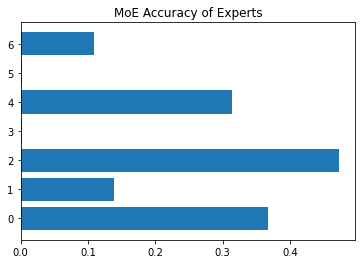

In [ ]:
plt.barh(list(range(C)), [accuracy_score(y_test,y_exp[k]) for k in range(C)])
plt.title("MoE Accuracy of Experts")